# Análisis de sentimientos

Es el proceso mediante el cual se busca detectar en un fragmento de texto los siguientes apartados:
    
    - Subjetividad, diferencia el contenido objetivo (hechos) del subjetivo (opiniones)
    - Polaridad, u orientación media de la emoción expresada. En general, positivo vs negativo y en ocasiones neutro.
    - Intensidad, fuerza del sentimiento u opinión expresada a veces en los documentos.

### Librerías y funciones necesarias

In [1]:
import pandas as pd
import numpy as np
import gzip
import os
import random
import operator

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
# Functions to read data json.gz a pandas data frame
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

In [4]:
# Función que cambiar el orden de una columna
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [5]:
# Función que devuelve un subconjunto de un dataframe balanceado por la columna indicada  
def balance_df(df, col_name, n_registros):
        
    # Aleatoriamente selecciona n_overall registros de cada grupo de la columna o variable indicada
    # reset_index: Reset the index of the DataFrame, and use the default one instead 
    df_result = df.groupby(col_name, as_index=False).apply(lambda x: x.sample(n=n_registros)).reset_index(drop=True)

    return df_result

In [6]:
# Función que dibuja la matriz de confusión
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicciones')
    plt.ylabel('Ground Truth')

    plt.tight_layout()
    plt.show()

### Carga de datos de varios datasets

Desde Amazon product data (Files "small" subsets for experimentation) con URL http://jmcauley.ucsd.edu/data/amazon/ descargamos los siguientes subsets:
    - Digital Music               (64,706 reviews)
    - Clothing, Shoes and Jewelry (278,677 reviews)
    - Health and Personal Care    (346,355 reviews)
    - Sports and Outdoors         (296,337 reviews)
    
5-core (9.9gb) - subset of the data in which all users and items have at least 5 reviews (41.13 million reviews)

In [7]:
# Read the data into a pandas data frame
df_music   = getDF('reviews_Digital_Music_5.json.gz')  
df_moda    = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
df_health  = getDF('reviews_Health_and_Personal_Care_5.json.gz')
df_sports  = getDF('reviews_Sports_and_Outdoors_5.json.gz')

In [8]:
# Comprobamos que las dimensiones sean correctas según la URL de AMAZON
print(f'Dimensiones del dataframe df_music:  ', df_music.shape)
print(f'Dimensiones del dataframe df_moda:   ', df_moda.shape)
print(f'Dimensiones del dataframe df_health: ', df_health.shape)
print(f'Dimensiones del dataframe df_sports: ', df_sports.shape)

Dimensiones del dataframe df_music:   (64706, 9)
Dimensiones del dataframe df_moda:    (278677, 9)
Dimensiones del dataframe df_health:  (346355, 9)
Dimensiones del dataframe df_sports:  (296337, 9)


In [9]:
# Todos los dataframes constan de las siguientes columnas:
df_music.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Detalle del significado de cada variable o columna:

    reviewerID - ID of the reviewer, e.g. A38IRL0X2T4DPF
    asin - ID of the product, e.g. 5555991584
    reviewerName - name of the reviewer
    helpful - helpfulness rating of the review, e.g. 2/3
    reviewText - text of the review
    overall - rating of the product
    summary - summary of the review
    unixReviewTime - time of the review (unix time)
    reviewTime - time of the review (raw)

In [10]:
# Analizamos las columna overall de cada dataset 
check_column(df_music, 'overall')
df_music['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 64706
overall consta de: 0 valores ausentes, 0.0%


5.0    35580
4.0    16536
3.0    6789 
2.0    3010 
1.0    2791 
Name: overall, dtype: int64

In [11]:
check_column(df_moda, 'overall')
df_moda['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 278677
overall consta de: 0 valores ausentes, 0.0%


5.0    163240
4.0    58357 
3.0    30425 
2.0    15463 
1.0    11192 
Name: overall, dtype: int64

In [12]:
check_column(df_health, 'overall')
df_health['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 346355
overall consta de: 0 valores ausentes, 0.0%


5.0    211633
4.0    68168 
3.0    33254 
2.0    16754 
1.0    16546 
Name: overall, dtype: int64

In [13]:
check_column(df_sports, 'overall')
df_sports['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 296337
overall consta de: 0 valores ausentes, 0.0%


5.0    188208
4.0    64809 
3.0    24071 
2.0    10204 
1.0    9045  
Name: overall, dtype: int64

### Dataframe combinando los datos 

El planteamiento es dado estos 4 datasets, extraemos de cada uno de ellos un nº de registros, exactamente 5000, teniendo en cuenta que los datos estén balanceados sobre la columna o variable overall que es la que indica el ratio del producto.

De manera que consideramos dos planteamientos:

    Problema de clasificación multiclase:
     - Si el valor es 1 o 2 --> sentimiento negativo
     - Si el valor es 3     --> sentimiento neutro
     - Si el valor es 4 o 5 --> sentimiento positivo
     
     Problema de clasificación binaria:
     - Si el valor es 1 o 2 --> sentimiento negativo
     - Si el valor es 4 o 5 --> sentimiento positivo
     

In [14]:
# Obtenemos un subconjunto de los data frames con datos balanceados con respecto a la columna overall 
# exactamente 1000 registros por categoría
# Primer con df_music
dfb_music   = balance_df(df_music, 'overall', 1000)
print(f'Dimensiones del dataframe dfb_music:  ', dfb_music.shape)

# Comprobamos que están balanceados
# dfb_music 
dfb_music['overall'].value_counts()

Dimensiones del dataframe dfb_music:   (5000, 9)


5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
Name: overall, dtype: int64

In [15]:
# Segundo con df_moda
dfb_moda = balance_df(df_moda, 'overall', 1000)
print(f'Dimensiones del dataframe dfb_moda:   ', dfb_moda.shape)

# Comprobar que dfb_moda está balanceado
dfb_moda['overall'].value_counts()

Dimensiones del dataframe dfb_moda:    (5000, 9)


5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
Name: overall, dtype: int64

In [16]:
# Tercero con df_health
dfb_health  = balance_df(df_health, 'overall', 1000)
print(f'Dimensiones del dataframe dfb_health: ', dfb_health.shape)

# Comprobar que dfb_health está balanceado
dfb_health['overall'].value_counts()

Dimensiones del dataframe dfb_health:  (5000, 9)


5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
Name: overall, dtype: int64

In [17]:
# Cuarto y último con dfb_sports
dfb_sports  = balance_df(df_sports, 'overall', 1000)
print(f'Dimensiones del dataframe dfb_sports: ', dfb_sports.shape)

# Comprobar que dfb_sports está balanceado
dfb_sports['overall'].value_counts()

Dimensiones del dataframe dfb_sports:  (5000, 9)


5.0    1000
4.0    1000
3.0    1000
2.0    1000
1.0    1000
Name: overall, dtype: int64

In [18]:
# Append rows of df (axis = 0 por defecto)
# ignore_index =True, do not use the index values along the concatenation axis. The resulting axis will be labeled 0, …, n - 1
df_amazon = pd.concat([dfb_music, dfb_moda, dfb_health, dfb_sports], ignore_index=True)
print(f'Dimensiones del dataframe df_amazon: ', df_amazon.shape)

# Análisis de la columna o variable overall
check_column(df_amazon, 'overall')

# Comprobamos que está balanceado
df_amazon['overall'].value_counts()

Dimensiones del dataframe df_amazon:  (20000, 9)
overall consta de: 5 valores distintos de un total de 20000
overall consta de: 0 valores ausentes, 0.0%


5.0    4000
4.0    4000
3.0    4000
2.0    4000
1.0    4000
Name: overall, dtype: int64

In [19]:
# Análisis de la columna reviewText para controlar Nan
check_column(df_amazon, 'reviewText')

reviewText consta de: 19995 valores distintos de un total de 20000
reviewText consta de: 0 valores ausentes, 0.0%


In [20]:
# Visualizamos las primeras filas 
df_amazon.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A319Y60NW7HS77,B000001EGI,"radiogold ""radiogold""","[2, 21]","Tumbleweed Connection raised Elton to his initial peak audibly with the hit single Country Comfort, and that legendary epic, Burn down the mission. It was the energy of that album that inspired the recording of 11-17-70, Live at the ANR Studios in New York City. In reality, this album was nothing but one long horrible noise. John's talents were wasted, with his vocals drowned in layers of instruments, which unfortunately destroyed the albums ambience. The eighteen minute version of burn down the mission became panned out to the point of very overdone. As much as I love listening to Elton's Music, this album was a rapid fall to failure. The modestly improved &quot;madman across the water&quot; and &quot;Honky chateau&quot;, were released in 1971 and 1972 respectively. but it would be the release of &quot;Don't shoot me, I'm only the piano player&quot;, and &quot;Good-bye yellow brick road&quot; in 1973, that would bring him back to his audible peak, and steer him well clear of this brief trench in his career.",1.0,"Just a brief dip, he would improve again!",1084752000,"05 17, 2004"
1,A15HQSBVCU724Y,B0002XEDSU,Mikky Mouse,"[3, 4]",Im not gonna review on this.. all i can say is that if you one of them trendy thugs that wear a rainbow colored fits & clothing (gay) and dance around in the middle of the streets (like a complete moron).. then go get this album.. If your a real rap listener and knows a definition of rap & Hip Hop.. avoid this album at all costs,1.0,That White Tee song is retarded,1134000000,"12 8, 2005"
2,AZ39SOZT3NZQU,B000FVQYYK,XraySpex,"[4, 67]","I bought this album because I went to a lyric site and their lyrics for a song on Absolution were insightful. Once I received the album I was consumed with disappointment. This world is suffering from the disease of delusion, religion is the opiate of the masses, and it is more destructive than heroin. The ignorance of musicians spouting their idiotic rhetoric, which perpetuates the myths that god exists and we have souls is sickening. Lyrics are a main component of music and musicians have to write lyrics that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artists will thrive in our culture and challenge the ignorance that infects everything.",1.0,Put This In A Black Hole,1184544000,"07 16, 2007"


In [21]:
# Guardamos el dataframe df_amazon 
# to_pickle: Pickle (serialize) object to file.
df_amazon.to_pickle('df_amazoncompleto.pkl')

In [22]:
# Comprobamos que al cargar el fichero pkl no hay diferencias
# Load pickled pandas object (or any object) from file.
df_newamazoncompleto = pd.read_pickle('df_amazoncompleto.pkl')

# Comprobamos que ambos dataframes son iguales
print(f'Dimensiones del dataframe df_newamazoncompleto: ', df_newamazoncompleto.shape)
print(f'Dimensiones del dataframe df_amazon: ', df_amazon.shape)

df_amazon.equals(df_newamazoncompleto)

Dimensiones del dataframe df_newamazoncompleto:  (20000, 9)
Dimensiones del dataframe df_amazon:  (20000, 9)


True

In [23]:
# Nos quedamos con las columnas necesarias para el análisis de sentimientos
# df_amazon = df_amazon.loc[:,'reviewText:overall']
df_amazon = df_amazon[['overall', 'reviewText']]

print(f'Dimensiones del dataframe df_amazon: ', df_amazon.shape)

Dimensiones del dataframe df_amazon:  (20000, 2)


In [24]:
# Función que define la etiqueta para el análisis de sentimientos multiclase
# según el valor de la columan overall
def label_multisentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    elif int(row['overall']) == 3:
        return 'neu'
    else:
        return 'pos'

In [25]:
# Función que define la etiqueta para el análisis de sentimientos binario
# según el valor de la columan overall
def label_bisentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [26]:
# Nuevas columnas en el df_amazon con la etiqueta de los sentimientos según contemplemos problema binario/multiclase
df_amazon['sentiment_trilabel'] = df_amazon.apply(lambda row: label_multisentiment(row), axis=1)
df_amazon['sentiment_bilabel'] = df_amazon.apply(lambda row: label_bisentiment(row), axis=1)

print(f'Dimensiones del dataframe df_amazon: ', df_amazon.shape)

Dimensiones del dataframe df_amazon:  (20000, 4)


In [27]:
# Chequeo del la etiqueta para problema binario (analisis de sentimientos)
check_column(df_amazon, 'sentiment_bilabel')
df_amazon['sentiment_bilabel'].value_counts()

sentiment_bilabel consta de: 2 valores distintos de un total de 20000
sentiment_bilabel consta de: 0 valores ausentes, 0.0%


pos    12000
neg    8000 
Name: sentiment_bilabel, dtype: int64

In [28]:
# Chequeo del la etiqueta para problema multiclase (analisis de sentimientos)
check_column(df_amazon, 'sentiment_trilabel')
df_amazon['sentiment_trilabel'].value_counts()

sentiment_trilabel consta de: 3 valores distintos de un total de 20000
sentiment_trilabel consta de: 0 valores ausentes, 0.0%


pos    8000
neg    8000
neu    4000
Name: sentiment_trilabel, dtype: int64

En ambos casos, comprobamos que la etiqueta para el análisis de sentimientos, contabiliza correctamente los totales:

    df_amazon['overall'].value_counts()

    5.0    4000
    4.0    4000
    3.0    4000
    2.0    4000
    1.0    4000

Por lo tanto trabajamos con una muestra balanceada.

Text(0.5, 1.0, 'Distribución de sentimiento')

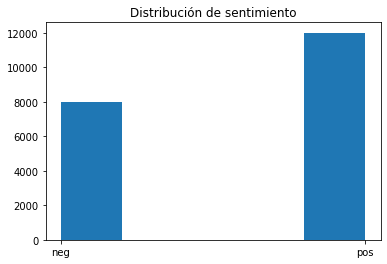

In [29]:
# Histograma (problema binario)
plt.hist(df_amazon['sentiment_bilabel'], bins=5)
plt.title("Distribución de sentimiento")

Text(0.5, 1.0, 'Distribución de sentimiento')

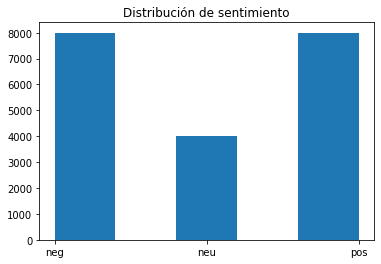

In [30]:
# Histograma (problema multiclase)
plt.hist(df_amazon['sentiment_trilabel'], bins=5)
plt.title("Distribución de sentimiento")

In [31]:
# Visualizamos las primeras filas
df_amazon.head(3)

,overall,reviewText,sentiment_trilabel,sentiment_bilabel
0,1.0,"Tumbleweed Connection raised Elton to his initial peak audibly with the hit single Country Comfort, and that legendary epic, Burn down the mission. It was the energy of that album that inspired the recording of 11-17-70, Live at the ANR Studios in New York City. In reality, this album was nothing but one long horrible noise. John's talents were wasted, with his vocals drowned in layers of instruments, which unfortunately destroyed the albums ambience. The eighteen minute version of burn down the mission became panned out to the point of very overdone. As much as I love listening to Elton's Music, this album was a rapid fall to failure. The modestly improved &quot;madman across the water&quot; and &quot;Honky chateau&quot;, were released in 1971 and 1972 respectively. but it would be the release of &quot;Don't shoot me, I'm only the piano player&quot;, and &quot;Good-bye yellow brick road&quot; in 1973, that would bring him back to his audible peak, and steer him well clear of this brief trench in his career.",neg,neg
1,1.0,Im not gonna review on this.. all i can say is that if you one of them trendy thugs that wear a rainbow colored fits & clothing (gay) and dance around in the middle of the streets (like a complete moron).. then go get this album.. If your a real rap listener and knows a definition of rap & Hip Hop.. avoid this album at all costs,neg,neg
2,1.0,"I bought this album because I went to a lyric site and their lyrics for a song on Absolution were insightful. Once I received the album I was consumed with disappointment. This world is suffering from the disease of delusion, religion is the opiate of the masses, and it is more destructive than heroin. The ignorance of musicians spouting their idiotic rhetoric, which perpetuates the myths that god exists and we have souls is sickening. Lyrics are a main component of music and musicians have to write lyrics that people can relate to in order to provide catharsis. Hopefully this band will cease to exist so intelligent artists will thrive in our culture and challenge the ignorance that infects everything.",neg,neg


In [32]:
# Función que devuelve la longitud del corpus de una columna de un dataframe
def lenCorpus(df, col_name):
  numTokens = set()
  for x in df[col_name]:
    for w in x.strip().split(' '):
      numTokens.add(w.strip())
  return len(numTokens)

In [33]:
print('Dimensiones del Corpus de df_amazon: ', {lenCorpus(df_amazon, 'reviewText')})

Dimensiones del Corpus de df_amazon:  {159223}


### División del dataframe en train y test  (Sin tratamiento de los datos)

Dividimos el dataframe airbnb_data en dos conjuntos, uno para training (entrenamiento) y otro para testing utizando:

    train_test_split = Split arrays or matrices into random train and test subsets con los parámetros:
      - shuffle = True   (orden aleatorio)
      - random_state = 42 (repetitibilidad de los datos) Using an int will produce the same results across different calls.
      - test_size = Represent the proportion of the dataset df_train 75% to include in the test split.
      - stratify: obtener unas muestras distribuidas según la etiqueta y = df_amazon['sentiment_trilabel']

In [34]:
# División del df df_amazon en train 75% y test 25%  balanceada respecto a sentiment_multilabel
# Dataframe_ df_amazon sin aplicar preprocesado ni lemmatización
amazon_train, amazon_test = train_test_split(
    df_amazon,
    train_size = 0.75,
    test_size=0.25, 
    random_state=42,    
    shuffle=True,       
    stratify = df_amazon['sentiment_trilabel']  
)

print(f'Datos entrenamiento: {amazon_train.shape}')
print(f'Datos test:  {amazon_test.shape}')

Datos entrenamiento: (15000, 4)
Datos test:  (5000, 4)


In [35]:
amazon_train.iloc[:3]

,overall,reviewText,sentiment_trilabel,sentiment_bilabel
2606,3.0,I wouldn't say this is Waylon Jennings best record. But it is very good. My favorite songs on here are Waymore's Blues and I've Been A Long Time Leaving. I had a few Waylon albums before I got this. And I didn't get this until 1981. The big song is Are You Sure Hank Done It This Way which is one of my favorite Waylon songs. It has Bob Wills Is Still The King. He does a version of I Recall A Gypsy Woman. And I think he did the first version of The Door Is Always Open on here. This is one of those albums that every song is good.,neu,pos
14234,5.0,"So easy to use and fast 1 second reading. I love that it has ear and forehead readings, because I always want to double check my temperatures. I have 3 little guys under age 5 and they have periods were they get fevers after immunizations, teething, and infections. There are two buttons F1 to scan the forehead from one side to another and F2 for scan the ear. Infrared readings allow me to take a temp without even touching or waking the kids.",pos,pos
12250,3.0,"This one is just okay, it doesn't really stimulate the clitoris as I hoped it would. Would not buy again.",neu,pos


In [36]:
# Verificamos que las muestras están balanceadas en train para el problema multiclase
amazon_train['sentiment_trilabel'].value_counts()

pos    6000
neg    6000
neu    3000
Name: sentiment_trilabel, dtype: int64

In [37]:
# Verificamos que las muestras están balanceadas en train para el problema binario
amazon_train['sentiment_bilabel'].value_counts()

pos    9000
neg    6000
Name: sentiment_bilabel, dtype: int64

### Extracción de features

CountVectorizer

    Convierte una colleción de documentos en una matriz de documentos-palabras. La codificación se realiza, por tanto, a nivel de documento, en lugar de a nivel de token.

    Al ser un modelo de bag-of-words, no se codifica la información relativa a la posición de los tokens ni su contexto, solo información a si aparecen y su frecuencia.

TF-IDF Vectorizer

    Term Frequency - Inverse Document Frequency es una medida de feature weighting que expresa lo relevante que es una palabra en un documento, siendo este documento parte de un corpus.


Parámetros:

    max_df = 0.95 --> Filtramos el 5% de las palabras que más se repiten
    min_df = 5    --> Eliminar palabras que no aparezcan al menos 5 veces
    max_features = 2000 --> Filtramos el nº de características a 2500
    ngram_range = (1, 2) --> trabajamos con palabras y bigramas
    stop_words

In [38]:
# CountVectorizer simple
cv_simple = CountVectorizer()
X_train_cv_simple = cv_simple.fit_transform(amazon_train['reviewText'])
X_test_cv_simple = cv_simple.transform(amazon_test['reviewText'])

# CountVectorizer simple + stop_words
cv_simple_sw = CountVectorizer(stop_words='english')
X_train_cv_simple_sw = cv_simple_sw.fit_transform(amazon_train['reviewText'])
X_test_cv_simple_sw  = cv_simple_sw.transform(amazon_test['reviewText'])

# CountVectorizer filter features
cv_complex = CountVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5)
X_train_cv_complex = cv_complex.fit_transform(amazon_train['reviewText'])
X_test_cv_complex = cv_complex.transform(amazon_test['reviewText'])

# CountVectorizer filter features +  stop_words
cv_complex_sw = CountVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5, stop_words='english')
X_train_cv_complex_sw = cv_complex_sw.fit_transform(amazon_train['reviewText'])
X_test_cv_complex_sw = cv_complex_sw.transform(amazon_test['reviewText'])

# TfIdfVectorizer simple
tfidf_simple = TfidfVectorizer()
X_train_tfidf_simple = tfidf_simple.fit_transform(amazon_train['reviewText'])
X_test_tfidf_simple = tfidf_simple.transform(amazon_test['reviewText'])

# TfIdfVectorizer simple + stop_words
tfidf_simple_sw = TfidfVectorizer(stop_words='english')
X_train_tfidf_simple_sw = tfidf_simple_sw.fit_transform(amazon_train['reviewText'])
X_test_tfidf_simple_sw = tfidf_simple_sw.transform(amazon_test['reviewText'])

# TfIdfVectorizer complejo (filter features)
tfidf_complex = TfidfVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5)
X_train_tfidf_complex = tfidf_complex.fit_transform(amazon_train['reviewText'])
X_test_tfidf_complex = tfidf_complex.transform(amazon_test['reviewText'])

# TfIdfVectorizer complejo (filter features) + stop_words
tfidf_complex_sw = TfidfVectorizer(ngram_range=(1, 2), max_features=2000, max_df=0.95, min_df=5, stop_words='english')
X_train_tfidf_complex_sw = tfidf_complex_sw.fit_transform(amazon_train['reviewText'])
X_test_tfidf_complex_sw = tfidf_complex_sw.transform(amazon_test['reviewText'])

In [39]:
print('Dimensiones del vocabulario cv_simple:       ', {len(cv_simple.vocabulary_)})
print('Dimensiones del vocabulario cv_simple_sw:    ', {len(cv_simple_sw.vocabulary_)})
print('Dimensiones del vocabulario cv_complex:      ', {len(cv_complex.vocabulary_)})
print('Dimensiones del vocabulario cv_complex_sw:   ', {len(cv_complex_sw.vocabulary_)})
print('Dimensiones del vocabulario tfidf_simple:    ', {len(tfidf_simple.vocabulary_)})
print('Dimensiones del vocabulario tfidf_simple_sw: ', {len(tfidf_simple_sw.vocabulary_)})
print('Dimensiones del vocabulario tfidf_complex:   ', {len(tfidf_complex.vocabulary_)})
print('Dimensiones del vocabulario tfidf_complex_sw:', {len(tfidf_complex_sw.vocabulary_)})

Dimensiones del vocabulario cv_simple:        {43036}
Dimensiones del vocabulario cv_simple_sw:     {42728}
Dimensiones del vocabulario cv_complex:       {2000}
Dimensiones del vocabulario cv_complex_sw:    {2000}
Dimensiones del vocabulario tfidf_simple:     {43036}
Dimensiones del vocabulario tfidf_simple_sw:  {42728}
Dimensiones del vocabulario tfidf_complex:    {2000}
Dimensiones del vocabulario tfidf_complex_sw: {2000}


### TF-IDF scores en train y test sets

In [40]:
print(f'TF-IFD Simple scores train: {X_train_tfidf_simple.shape}')
print(f'TF-IFD Simple scores test:  {X_test_tfidf_simple.shape}')

TF-IFD Simple scores train: (15000, 43036)
TF-IFD Simple scores test:  (5000, 43036)


In [41]:
print(f'TF-IFD Complex scores train: {X_train_tfidf_complex.shape}')
print(f'TF-IFD Complex scores test:  {X_test_tfidf_complex.shape}')

TF-IFD Complex scores train: (15000, 2000)
TF-IFD Complex scores test:  (5000, 2000)


### Score IDF de algunas palabras

In [42]:
# Diccionario con las 2000 features que hemos extraido pj de tfidf_complex
vocab_idfcomplex = dict(zip(tfidf_complex.get_feature_names(), tfidf_complex.idf_))
print('Dimensiones del vocabulario tfidf_complex:   ', {len(vocab_idfcomplex)})
vocab_idfcomplex

Dimensiones del vocabulario tfidf_complex:    {2000}


{'10': 4.070522484194471,
 '100': 5.1187039192356885,
 '11': 5.337757485298373,
 '12': 4.942548877357398,
 '13': 5.625439557750154,
 '15': 4.973965073590777,
 '16': 5.853698209731134,
 '20': 4.8017416127038235,
 '25': 5.6886184593716855,
 '30': 4.9810825413596405,
 '34': 4.117589995052457,
 '40': 5.3688480723684044,
 '50': 4.757938990045431,
 '50 cent': 5.961911794371367,
 '70': 5.779590237577413,
 '80': 5.528275809296506,
 '8217': 6.926992690414954,
 '90': 5.7483376940733075,
 'able': 4.3582045566462515,
 'able to': 4.389335475241425,
 'about': 2.705281532272412,
 'about it': 5.135233221186899,
 'about the': 4.482474101532242,
 'about this': 4.889024396941693,
 'above': 5.190922127047488,
 'absolutely': 4.984660362707524,
 'accurate': 5.497878332112135,
 'acoustic': 5.779590237577413,
 'across': 5.5344677795444275,
 'actual': 5.47420858802623,
 'actually': 3.86477067559213,
 'add': 4.935699535511823,
 'added': 5.434088594236806,
 'addition': 5.598592307713966,
 'adjust': 5.61865987076

In [43]:
# Ordenamos el diccionario por valores decrecientes value
sortvocab_idfcomplex = sorted(vocab_idfcomplex.items(), key=operator.itemgetter(1),  reverse=True)
sortvocab_idfcomplex

[('fish oil', 7.181884940043744),
 ('omega', 7.11936458306241),
 ('8217', 6.926992690414954),
 ('tori', 6.854672028835328),
 ('shaver', 6.555429133982471),
 ('rack', 6.538334700623171),
 ('elton', 6.441484874633253),
 ('trimmer', 6.4262174025024645),
 ('ja', 6.396364439352784),
 ('fish', 6.381765639931631),
 ('scale', 6.381765639931631),
 ('the watch', 6.2720667226752065),
 ('dre', 6.2214229898564515),
 ('hat', 6.2214229898564515),
 ('the knife', 6.185055345685576),
 ('michael', 6.161524848275382),
 ('pads', 6.149964025874307),
 ('the bag', 6.12723577479675),
 ('nas', 6.116062474198626),
 ('bags', 6.10501263801204),
 ('holster', 6.09408356747985),
 ('shower', 6.09408356747985),
 ('cap', 6.083272651375634),
 ('door', 6.083272651375634),
 ('this knife', 6.072577362258887),
 ('pad', 6.06199525292835),
 ('phone', 6.06199525292835),
 ('the unit', 6.051523953061054),
 ('pump', 6.041161166025508),
 ('remix', 6.0207522943943),
 ('flip', 6.010701958540799),
 ('sugar', 6.010701958540799),
 ('las

In [44]:
# Top 10 de los palabras con mayor  IDF
sortvocab_idfcomplex[0:10]

[('fish oil', 7.181884940043744),
 ('omega', 7.11936458306241),
 ('8217', 6.926992690414954),
 ('tori', 6.854672028835328),
 ('shaver', 6.555429133982471),
 ('rack', 6.538334700623171),
 ('elton', 6.441484874633253),
 ('trimmer', 6.4262174025024645),
 ('ja', 6.396364439352784),
 ('fish', 6.381765639931631)]

In [45]:
# Top 10 de los palabras con menor  IDF  (nuestro diccionario está compuesto por 2000 features)
sortvocab_idfcomplex[1990:2000]

[('in', 1.6555327780367999),
 ('but', 1.5946362816434947),
 ('for', 1.5692278652234974),
 ('of', 1.5057941944911017),
 ('is', 1.4454167062516226),
 ('this', 1.4301318894209403),
 ('it', 1.3473572085016354),
 ('to', 1.3080421512754503),
 ('and', 1.2210458929293764),
 ('the', 1.1525187876362202)]

### Palabras con el TF-IDF en alguna review

In [46]:
# Seleccionamos aleatoriamente una review para extraer las palabras junto con su TF-IDF 
i = random.randint(0, len(amazon_train))
print('ID: {}'.format(i))
print('SentimentLabel: {}'.format(amazon_train['sentiment_bilabel'].iloc[i]))
print('ReviewText: {}'.format(amazon_train['reviewText'].iloc[i]))

ID: 13425
SentimentLabel: neg
ReviewText: Ive used Everlast before, for YEARS. Sadly, the Everlast of the 70's and 80's is LONG GONE.  Virtually EVERY product that Everlast makes, from apparel to boxing equipment is so poorly made, it has earned the title "NEVERLAST".  This speed bag is no exception. Ive purchased 2 bags now in haste because I had a group training session and the REAL BAGS had not arrived yet. Neither bags lasted more than a couple of weeks. The Leather feels good and the stitching APPEARS well done but, therin lies ONE of the problems. The seams start coming apart after moderate use and the bladders cannot sustain air. The bladders were meticulously filled and the bags never underwent heavy strikes. It was used for timing and response training as it should. The guy at the sporting goods store said they gave refunds for them as fast they sold them but, that was the only brand the company would furnish them with. Many others have reported the same thing with their produ

In [47]:
# Aplicamos la muestra obtenida con está técnica de extracción de features tfidf_complex
doc_vector = X_train_tfidf_complex[i]
df_tfidfcomplex = pd.DataFrame(doc_vector.T.todense(), index=tfidf_complex.get_feature_names(), columns=['tfidf'])
df_tfidfcomplex = df_tfidfcomplex[df_tfidfcomplex['tfidf'] > 0]

# Top n
top_n = 10
print('Top {} words with highest TF_IDF Nº {}:\n{}'.format(top_n, i, df_tfidfcomplex.sort_values(by=["tfidf"], ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF Nº {}:\n{}'.format(top_n, i, df_tfidfcomplex.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF Nº 13425:
              tfidf
bags       0.374437
the        0.318092
and the    0.171723
and        0.149780
title      0.144039
purchased  0.134303
as         0.128681
them       0.120421
for        0.120306
years      0.110569

Top 10 words with lowest TF_IDF Nº 13425:
         tfidf
at    0.036060
or    0.036036
good  0.035934
if    0.034032
so    0.032383
are   0.029822
have  0.029340
my    0.027676
not   0.026822
to    0.020056


### 𝜒²  scores

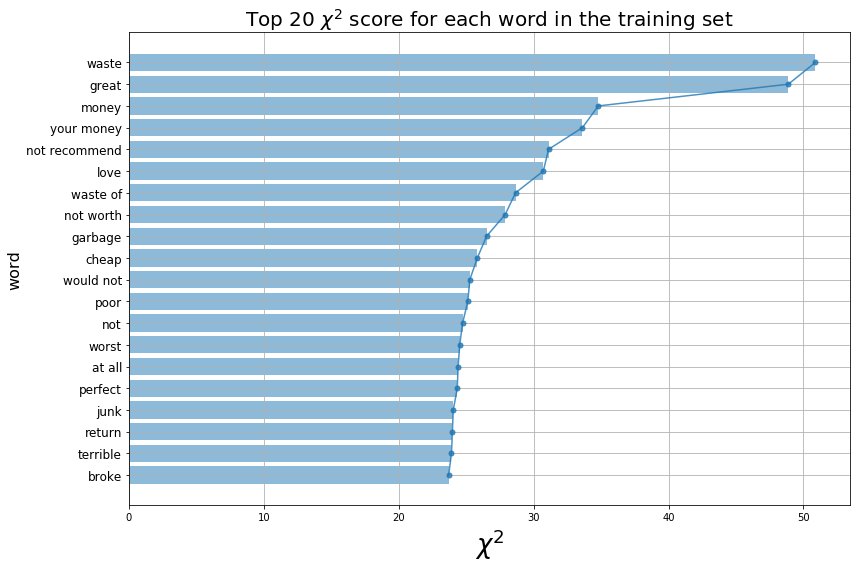

In [48]:
# Compute the chi-squared score for each word in the training set and show the values (tfidf_complex)
i = 20 

chi2score = chi2(X_train_tfidf_complex, amazon_train['sentiment_bilabel'])[0]
scores = list(zip(tfidf_complex.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento - Modelo LogisticRegression para el problema de clasificación binaria

In [49]:
# Para el problema de clasificación binaria aplicamos el modelo LogisticRegression
# The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization with primal formulation, or no regularization
lr_cv_simple        = LogisticRegression(solver='lbfgs')  # obtengo mejores resultados
lr_cv_simple_sw     = LogisticRegression(solver='lbfgs')
lr_cv_complex       = LogisticRegression(solver='lbfgs')
lr_cv_complex_sw    = LogisticRegression(solver='lbfgs')
lr_tfidf_simple     = LogisticRegression(solver='lbfgs')
lr_tfidf_simple_sw  = LogisticRegression(solver='lbfgs')
lr_tfidf_complex    = LogisticRegression(solver='lbfgs')
lr_tfidf_complex_sw = LogisticRegression(solver='lbfgs')

In [50]:
# Función que realiza el entrenamiento en training y predice test con algunas métricas (matriz de confusión, accuracy)
def  model_training(lr_model, X_train, y_train, X_test, y_test):
    
    lr_model.fit(X_train, y_train)
    y_predict = lr_model.predict(X_test)
   
    print('Modelo: ', {lr_model})
    print(confusion_matrix(y_test, y_predict))
    print(classification_report(y_test, y_predict))
    print('Accuracy score:{}'.format(accuracy_score(y_test, y_predict)))
    
    plot_confusion_matrix(confusion_matrix(y_test, y_predict))
    

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1395  605]
 [ 520 2480]]
              precision    recall  f1-score   support

         neg       0.73      0.70      0.71      2000
         pos       0.80      0.83      0.82      3000

    accuracy                           0.78      5000
   macro avg       0.77      0.76      0.76      5000
weighted avg       0.77      0.78      0.77      5000

Accuracy score:0.775


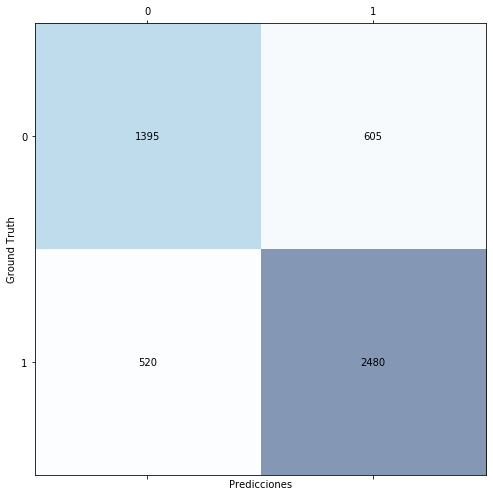

In [51]:
# Modelo 1. CountVectorizer simple - LogisticRegression
model_training(lr_cv_simple, X_train_cv_simple,  amazon_train['sentiment_bilabel'], 
                             X_test_cv_simple, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1347  653]
 [ 551 2449]]
              precision    recall  f1-score   support

         neg       0.71      0.67      0.69      2000
         pos       0.79      0.82      0.80      3000

    accuracy                           0.76      5000
   macro avg       0.75      0.74      0.75      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.7592


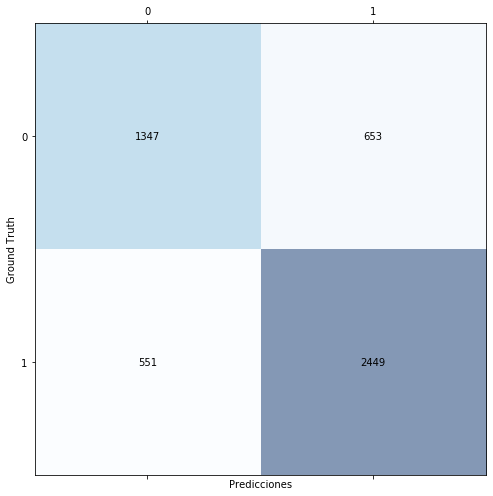

In [52]:
# Modelo 2. CountVectorizer simple + stop_words - LogisticRegression
model_training(lr_cv_simple_sw, X_train_cv_simple_sw,  amazon_train['sentiment_bilabel'], 
                                X_test_cv_simple_sw, amazon_test['sentiment_bilabel'])

                    CountVectorizer simple                    CountVectorizer simple con stop_words
    
    M.confusión     [[1395  605]   Falsos negativos: 605      [[1347  653]   Falsos negativos: 653       
                     [ 520 2480]]  Falsos positivos: 520       [ 551 2449]]  Falsos positivos: 551
    
    Accuracy        0.775                                     0.7592


    El mejor resultado obtenido es el modelo sin aplicar stop_words, tanto en accuracy como en falsos positivos y negativos. 

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1349  651]
 [ 523 2477]]
              precision    recall  f1-score   support

         neg       0.72      0.67      0.70      2000
         pos       0.79      0.83      0.81      3000

    accuracy                           0.77      5000
   macro avg       0.76      0.75      0.75      5000
weighted avg       0.76      0.77      0.76      5000

Accuracy score:0.7652


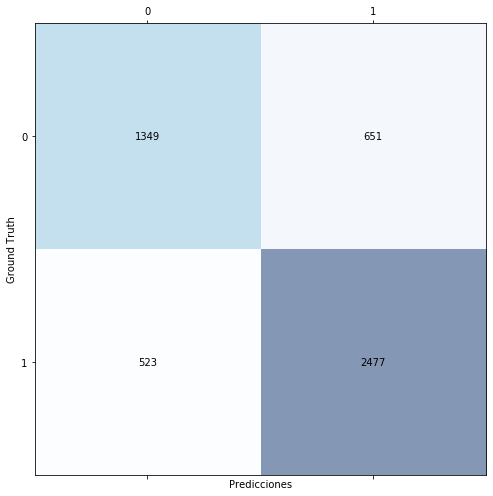

In [53]:
# Modelo 3. CountVectorizer filter features - LogisticRegression
model_training(lr_cv_complex, X_train_cv_complex,  amazon_train['sentiment_bilabel'], 
                              X_test_cv_complex, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1317  683]
 [ 520 2480]]
              precision    recall  f1-score   support

         neg       0.72      0.66      0.69      2000
         pos       0.78      0.83      0.80      3000

    accuracy                           0.76      5000
   macro avg       0.75      0.74      0.75      5000
weighted avg       0.76      0.76      0.76      5000

Accuracy score:0.7594


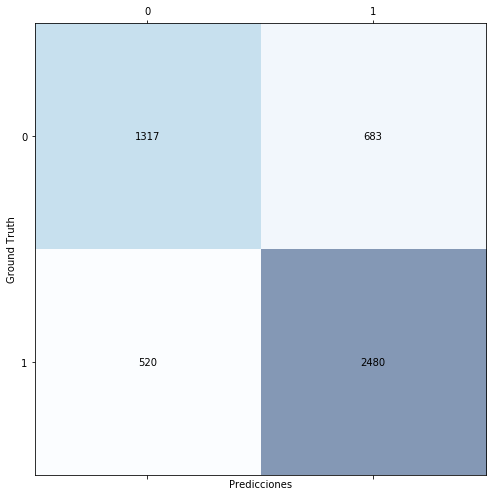

In [54]:
# Modelo 4. CountVectorizer filter features + stop_words - LogisticRegression
model_training(lr_cv_complex_sw, X_train_cv_complex_sw,  amazon_train['sentiment_bilabel'], 
                                 X_test_cv_complex_sw, amazon_test['sentiment_bilabel'])

                    CountVectorizer filter features           CountVectorizer filter features con stop_words

    M.confusión     [[1349  651]   Falsos negativos: 651      [[1317  683]   Falsos negativos: 683       
                     [ 523 2477]]  Falsos positivos: 523      [ 520 2480]]   Falsos positivos: 520

    Accuracy        0.7652                                    0.7594
    
    Son modelos con resultados similares, algo mejor el primer modelo sin aplicar stop_words

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1269  731]
 [ 376 2624]]
              precision    recall  f1-score   support

         neg       0.77      0.63      0.70      2000
         pos       0.78      0.87      0.83      3000

    accuracy                           0.78      5000
   macro avg       0.78      0.75      0.76      5000
weighted avg       0.78      0.78      0.77      5000

Accuracy score:0.7786


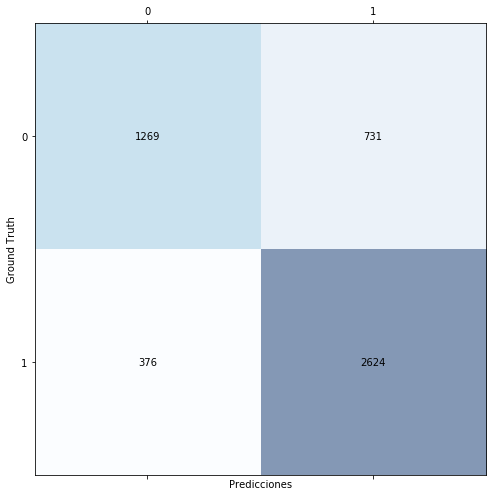

In [55]:
# Modelo 5. TfIdfVectorizer simple - - LogisticRegression
model_training(lr_tfidf_simple, X_train_tfidf_simple,  amazon_train['sentiment_bilabel'], 
                                X_test_tfidf_simple, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1219  781]
 [ 360 2640]]
              precision    recall  f1-score   support

         neg       0.77      0.61      0.68      2000
         pos       0.77      0.88      0.82      3000

    accuracy                           0.77      5000
   macro avg       0.77      0.74      0.75      5000
weighted avg       0.77      0.77      0.77      5000

Accuracy score:0.7718


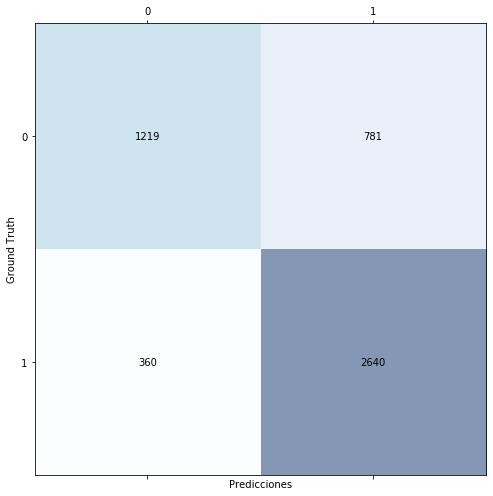

In [56]:
# Modelo 6. TfIdfVectorizer simple +  stop_words - - LogisticRegression
model_training(lr_tfidf_simple_sw, X_train_tfidf_simple_sw,  amazon_train['sentiment_bilabel'], 
                                   X_test_tfidf_simple_sw, amazon_test['sentiment_bilabel'])

                    TfidfVectorizer simple                    TfidfVectorizer simple con stop_words

    M.confusión     [[1264  736]   Falsos negativos: 736      [[1219  781]   Falsos negativos: 781       
                     [ 376 2624]]  Falsos positivos: 376      [ 360 2640]]   Falsos positivos: 360 

    Accuracy        0.7786                                    0.7718
    
    Son modelos con resultados similares, algo mejor el primer modelo sin aplicar stop_words

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1317  683]
 [ 399 2601]]
              precision    recall  f1-score   support

         neg       0.77      0.66      0.71      2000
         pos       0.79      0.87      0.83      3000

    accuracy                           0.78      5000
   macro avg       0.78      0.76      0.77      5000
weighted avg       0.78      0.78      0.78      5000

Accuracy score:0.7836


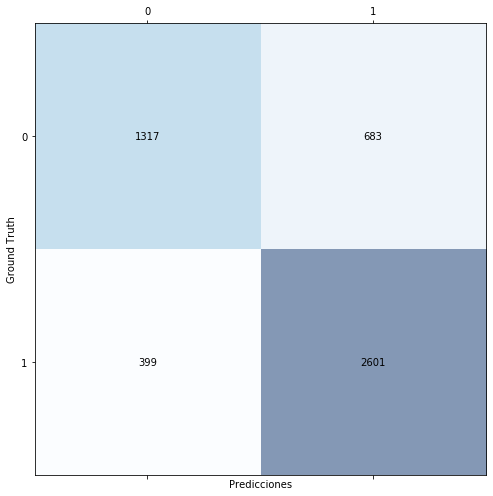

In [57]:
# Modelo 7. TfIdfVectorizer filter features - - LogisticRegression
model_training(lr_tfidf_complex, X_train_tfidf_complex,  amazon_train['sentiment_bilabel'], 
                                 X_test_tfidf_complex, amazon_test['sentiment_bilabel'])

Modelo:  {LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)}
[[1259  741]
 [ 414 2586]]
              precision    recall  f1-score   support

         neg       0.75      0.63      0.69      2000
         pos       0.78      0.86      0.82      3000

    accuracy                           0.77      5000
   macro avg       0.76      0.75      0.75      5000
weighted avg       0.77      0.77      0.76      5000

Accuracy score:0.769


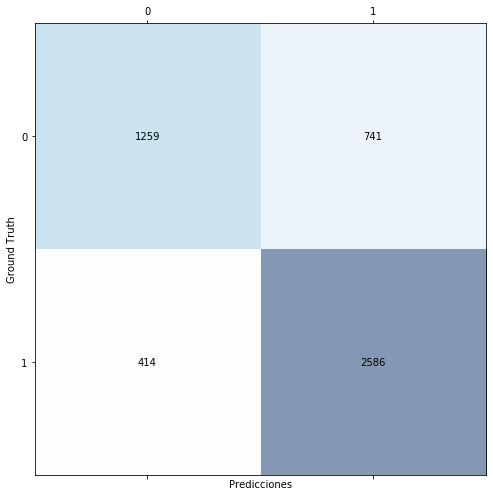

In [58]:
# Modelo 8. TfIdfVectorizer filter features + stop_words - - LogisticRegression
model_training(lr_tfidf_complex_sw, X_train_tfidf_complex_sw,  amazon_train['sentiment_bilabel'], 
                                    X_test_tfidf_complex_sw, amazon_test['sentiment_bilabel'])

                    TfidfVectorizer filter features           TfidfVectorizer filter features con stop_words

    M.confusión     [[1317  683]   Falsos negativos: 683      [[1259  741]   Falsos negativos: 741       
                     [ 399 2601]]  Falsos positivos: 399      [ 414 2586]]   Falsos positivos: 414 

    Accuracy        0.7836                                   0.769
    
    En este caso el mejor resultado es el primer modelo sin stop_words tanto en accuracy como en falsos negativos y falsos positivos.

### Predicciones 

In [59]:
# Función que predice el analísis de sentimiento según el review de un dataframe
def predict_review_sentiment(df, review_index, col_name, col_label,  model, cv):
    print('Actual sentiment: {}'.format(df.iloc[review_index][col_label]))
    r = df.iloc[review_index][col_name]
    print('Prediction: {}'.format(model.predict(cv.transform([r]))))

In [61]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer filter features sin aplicar stop_words
for i in random.sample(range(0, len(df_amazon)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon, i, 'reviewText', 'sentiment_bilabel', lr_tfidf_complex, tfidf_complex)


Review no. 19909
Actual sentiment: pos
Prediction: ['pos']

Review no. 9267
Actual sentiment: pos
Prediction: ['pos']

Review no. 6653
Actual sentiment: neg
Prediction: ['neg']

Review no. 12009
Actual sentiment: pos
Prediction: ['neg']

Review no. 6762
Actual sentiment: neg
Prediction: ['neg']


In [63]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer simple sin aplicar stop_words
for i in random.sample(range(0, len(df_amazon)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon, i, 'reviewText', 'sentiment_bilabel', lr_tfidf_simple, tfidf_simple)


Review no. 7533
Actual sentiment: pos
Prediction: ['pos']

Review no. 914
Actual sentiment: neg
Prediction: ['neg']

Review no. 10746
Actual sentiment: neg
Prediction: ['neg']

Review no. 11787
Actual sentiment: neg
Prediction: ['neg']

Review no. 18283
Actual sentiment: pos
Prediction: ['pos']


Observamos que en la clasificación binario, algunas predicciones no han sido las esperadas en las Review no. 12009

### Conclusiones para el problema de clasificación binaria

Aplicando estas técnicas para la extracción de carácterísticas
    
    CountVectorizer simple
    CountVectorizer filter features
    TfidfVectorizer simple
    TfidfVectorizer filter features
    
y sus combinaciones con stop_words junto con un modelo  LogisticRegression para el problema de regresión binario.

Concluimos que el mejor resultado corresponde a la cuarta técnica:
    
    "TfidfVectorizer filter features" sin stop_words (accurary en test 78.36%)

### Entrenamiento - Modelo Random Forest para el problema de clasificación multiclase

In [64]:
# Función que entrena el modelo Random Forest y obtiene hiperparámetro óptimo max_depth
# y calcula su score tanto en train como en test
def optimal_rfmodel (nmax, X_train, y_train, X_test, y_test):
    maxDepth = range(1,nmax)
    tuned_parameters = {'max_depth': maxDepth}

    grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
    grid.fit(X_train, y_train)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))

    scores = np.array(grid.cv_results_['mean_test_score'])
    plt.plot(maxDepth,scores,'-o')
    plt.xlabel('max_depth')
    plt.ylabel('10-fold ACC')

    plt.show()
    
    maxDepthOptimo = grid.best_params_['max_depth']
    rdModel = RandomForestClassifier(max_depth=maxDepthOptimo,
                                 n_estimators=200,max_features='sqrt').fit(X_train, y_train)

    print("Train: ",rdModel.score(X_train, y_train))
    print("Test:  ", rdModel.score(X_test, y_test))

best mean cross-validation score: 0.631
best parameters: {'max_depth': 14}


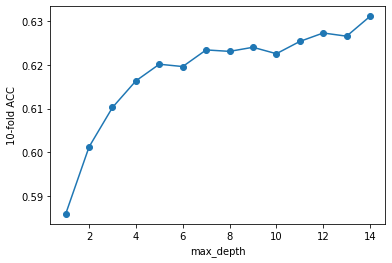

Train:  0.7176
Test:   0.6222


In [65]:
# Probaremos con las técnicas en las que hemos aplicado filtrado de features 
# Modelo 1. CountVectorizer filter features 
optimal_rfmodel (15, X_train_cv_complex, amazon_train['sentiment_trilabel'], 
                     X_test_cv_complex, amazon_test['sentiment_trilabel'])

In [66]:
# Probamos con otros valores de max_depth y optamos por el valor a 8
rdModel = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_cv_complex,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel.score(X_train_cv_complex, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel.score(X_test_cv_complex, amazon_test['sentiment_trilabel']))

Train:  0.6582
Test:  0.6232


    Con el max_depth óptimo = 14 (The maximum depth of the tree) se obtiene el siguiente resultado:

        71.76% Train
        62.22% Test

    La profundidad del árbol es muy elevada para este resultados.
    Probamos con max_depth 8 (65.82% Train y 62.32% Test), y consideramos este valor como bueno ya que de este modo simplificaríamos la complejidad del modelo.

best mean cross-validation score: 0.622
best parameters: {'max_depth': 14}


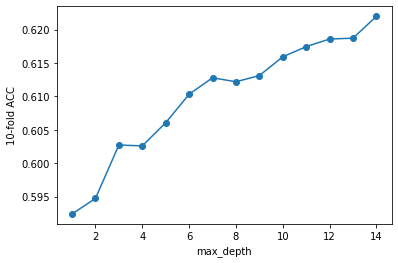

Train:  0.6715333333333333
Test:   0.6162


In [67]:
# Modelo 2. CountVectorizer filter features  + stop_words
optimal_rfmodel (15, X_train_cv_complex_sw, amazon_train['sentiment_trilabel'], 
                     X_test_cv_complex_sw, amazon_test['sentiment_trilabel'])

In [68]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel2 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_cv_complex_sw,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel2.score(X_train_cv_complex_sw, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel2.score(X_test_cv_complex_sw, amazon_test['sentiment_trilabel']))

Train:  0.6306666666666667
Test:  0.6002


                    CountVectorizer filter features           CountVectorizer filter features con stop_words

    max_depth         14             8                              14             8
    Train            71.76%        65.82%                          67.15%        63.06%
    Test             62.22%        62.32%                          61.62%        60.02%   
    
    No son buenos resultados pero quiza optara por el primer modelo aunque exista overfitting
    CountVectorizer filter features sin stop_words con max_depth a 8 + con un score de 62.32% para test y 66% aprox. para train reduciremos la complejidad del modelo.

best mean cross-validation score: 0.629
best parameters: {'max_depth': 14}


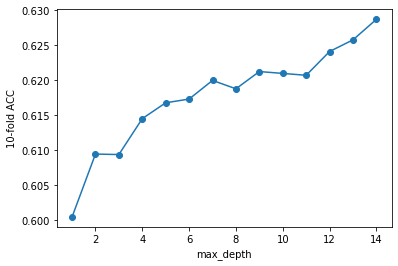

Train:  0.7189333333333333
Test:   0.6284


In [69]:
# Modelo 3. Tfidf filter features  
optimal_rfmodel (15, X_train_tfidf_complex, amazon_train['sentiment_trilabel'], 
                     X_test_tfidf_complex, amazon_test['sentiment_trilabel'])

In [70]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel3 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_tfidf_complex,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel3.score(X_train_tfidf_complex, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel3.score(X_test_tfidf_complex, amazon_test['sentiment_trilabel']))

Train:  0.6584
Test:  0.6168


best mean cross-validation score: 0.620
best parameters: {'max_depth': 14}


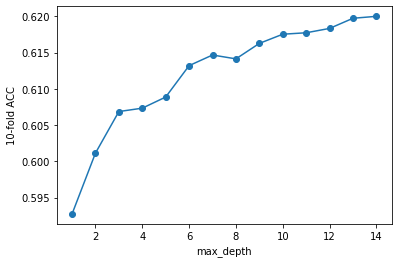

Train:  0.6791333333333334
Test:   0.6212


In [71]:
# Modelo 4. Tfidf filter features  + stop_words
optimal_rfmodel (15, X_train_tfidf_complex_sw, amazon_train['sentiment_trilabel'], 
                     X_test_tfidf_complex_sw, amazon_test['sentiment_trilabel'])

In [72]:
# Probamos con otros valores de max_depth pj para el valor a 8
rdModel4 = RandomForestClassifier(max_depth=8,
                                 n_estimators=200,max_features='sqrt').fit(X_train_tfidf_complex_sw,amazon_train['sentiment_trilabel'])

print("Train: ",rdModel4.score(X_train_tfidf_complex_sw, amazon_train['sentiment_trilabel']))
print("Test: ", rdModel4.score(X_test_tfidf_complex_sw, amazon_test['sentiment_trilabel']))

Train:  0.6497333333333334
Test:  0.6148


                    TfidfVectorizer filter features           TfidfVectorizer filter features con stop_words

    max_depth         14             8                              14             8
    Train            71.89%        65.84%                          67.91%        64.97%
    Test             62.84%        61.68%                          62.12%        61.48%   
    
    En ambos casos el resultado es similar un 65-66% en train y 62% en test para max_depth = 8

### Predicciones

In [73]:
# Aplicamos esta predicción sobre el modelo con mejores resultados CountVectorizer filter features sin aplicar stop_words
# y para el modelo con max_depth=8
for i in random.sample(range(0, len(df_amazon)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon, i, 'reviewText', 'sentiment_trilabel', rdModel, cv_complex)


Review no. 15378
Actual sentiment: neg
Prediction: ['neg']

Review no. 7998
Actual sentiment: neu
Prediction: ['neg']

Review no. 10930
Actual sentiment: neg
Prediction: ['neg']

Review no. 5456
Actual sentiment: neg
Prediction: ['neg']

Review no. 6462
Actual sentiment: neg
Prediction: ['neg']


In [74]:
# Aplicamos esta predicción sobre el modelo con mejores resultados TfidfVectorizer filter features sin aplicar stop_words
# y para el modelo con max_depth=8
for i in random.sample(range(0, len(df_amazon)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(df_amazon, i, 'reviewText', 'sentiment_trilabel', rdModel3, tfidf_complex)


Review no. 11073
Actual sentiment: neg
Prediction: ['neg']

Review no. 19712
Actual sentiment: pos
Prediction: ['pos']

Review no. 5681
Actual sentiment: neg
Prediction: ['pos']

Review no. 1355
Actual sentiment: neg
Prediction: ['neg']

Review no. 13268
Actual sentiment: pos
Prediction: ['pos']


Observamos que en la clasificación multiclase, algunas predicciones no han sido las esperadas en las Reviews no. 5681 y 7998

### Conclusiones para el problema de clasificación multiclase

    Aplicando estas técnicas para la extracción de carácterísticas

    CountVectorizer filter features
    TfidfVectorizer filter features

    y sus combinaciones con stop_words junto con un modelo LogisticRegression para el problema de regresión multiclase.

    Concluimos que el mejor resultado corresponde a la segunda técnica:

    "TfidfVectorizer filter features" sin/con stop_words (accurary en test 62% y para  train 66%) con max_depth = 8

### Conclusión 

    Partiendo del df_amazon combinado con 4 subsets balanceado respecto la columna overall, sin aplicar ningún procesado ni lematización.
    
    Para el problema de clasificación binaria, aplicamos estas técnicas para la extracción de carácterísticas:

    - CountVectorizer simple
    - CountVectorizer filter features
    - TfidfVectorizer simple
    - TfidfVectorizer filter features
    y sus combinaciones con stop_words junto con un modelo LogisticRegression
    
    Para el problema de clasificación multiclase, aplicamos las técnicas:
    - CountVectorizer filter features
    - TfidfVectorizer filter features    
    y sus combinaciones con stop_words junto con un modelo RandomForest.

    Los mejores resultados han sido:
    
    - Clasificación binaria:    TfidfVectorizer filter features" sin stop_words (accurary en test 78.36%)         
    - Clasificación multiclase: TfidfVectorizer filter features" sin stop_words (accurary en test 62% y para train 65%)    

    Concluimos que se obtienen mejores resultados para el problema de clasificación binario ya que entendemos que es más 
    difícil la predicción de la clase neutra en la clasificación multiclase, tal y como se observan en el resultados 
    obtenidos.